# Importações

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

In [13]:
# Criação do dataframe 
df_censo = pd.read_csv('database_dropout.csv')

df_censo.drop(columns=['NO_REGIAO', 'SG_UF','CO_MUNICIPIO', 'NO_MUNICIPIO', 'CO_ENTIDADE','NO_ENTIDADE', 'NO_CATEGORIA','NO_DEPENDENCIA'], inplace=True)

# Informações do dataframe
df_censo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130129 entries, 0 to 130128
Data columns (total 44 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   TX_APROV_FUND                   130129 non-null  float64
 1   TX_APROV_MED                    130129 non-null  float64
 2   TX_REPR_FUND                    130129 non-null  float64
 3   TX_REPR_MED                     130129 non-null  float64
 4   TX_DIS_FUND                     130129 non-null  float64
 5   TX_DIS_MED                      130129 non-null  float64
 6   M_ATU_FUND                      130129 non-null  float64
 7   M_ATU_MED                       130129 non-null  float64
 8   TX_DSU_FUND                     130129 non-null  float64
 9   TX_DSU_MED                      130129 non-null  float64
 10  M_HAU_FUND                      130129 non-null  float64
 11  M_HAU_MED                       130129 non-null  float64
 12  IN_AGUA_INEXISTE

# Funções

In [14]:
def exibe_graficos_coluna(df, coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plotar histograma
    sns.histplot(data=df, x=coluna, ax=ax1)
    ax1.set_title(f'Histograma - {coluna}')
    ax1.tick_params(axis='x', rotation=45)
    
    # Plotar boxplot
    sns.boxplot(data=df, y=coluna, ax=ax2)
    ax2.set_title(f'Boxplot - {coluna}')
    
    plt.tight_layout()
    plt.show()

# EDA

In [15]:
# Copiar DF para DF EDA
df_censo_eda = df_censo.copy()

# Converter para booleano
df_censo_eda['IN_INTERNET'] = df_censo_eda['IN_INTERNET'].astype(bool)
df_censo_eda['IN_SALA_PROFESSOR'] = df_censo_eda['IN_SALA_PROFESSOR'].astype(bool)
df_censo_eda['IN_AGUA_INEXISTENTE'] = df_censo_eda['IN_AGUA_INEXISTENTE'].astype(bool)
df_censo_eda['IN_ENERGIA_INEXISTENTE'] = df_censo_eda['IN_ENERGIA_INEXISTENTE'].astype(bool)
df_censo_eda['IN_ESGOTO_INEXISTENTE'] = df_censo_eda['IN_ESGOTO_INEXISTENTE'].astype(bool)
df_censo_eda['IN_AUDITORIO'] = df_censo_eda['IN_AUDITORIO'].astype(bool)
df_censo_eda['IN_BANHEIRO'] = df_censo_eda['IN_BANHEIRO'].astype(bool)
df_censo_eda['IN_BIBLIOTECA'] = df_censo_eda['IN_BIBLIOTECA'].astype(bool)
df_censo_eda['IN_LABORATORIO_INFORMATICA'] = df_censo_eda['IN_LABORATORIO_INFORMATICA'].astype(bool)
df_censo_eda['IN_PARQUE_INFANTIL'] = df_censo_eda['IN_PARQUE_INFANTIL'].astype(bool)
df_censo_eda['IN_PISCINA'] = df_censo_eda['IN_PISCINA'].astype(bool)
df_censo_eda['IN_REFEITORIO'] = df_censo_eda['IN_REFEITORIO'].astype(bool)
df_censo_eda['IN_SALA_LEITURA'] = df_censo_eda['IN_SALA_LEITURA'].astype(bool)
df_censo_eda['IN_SALA_PROFESSOR'] = df_censo_eda['IN_SALA_PROFESSOR'].astype(bool)
df_censo_eda['IN_ACESSIBILIDADE_INEXISTENTE'] = df_censo_eda['IN_ACESSIBILIDADE_INEXISTENTE'].astype(bool)
df_censo_eda['IN_QUADRA_ESPORTES'] = df_censo_eda['IN_QUADRA_ESPORTES'].astype(bool)

# converte  inteiros
df_censo_eda['IN_TRATAMENTO_LIXO_INEXISTENTE'] = df_censo_eda['IN_TRATAMENTO_LIXO_INEXISTENTE'].astype(int)
df_censo_eda['QT_SALAS_UTILIZADAS'] = df_censo_eda['QT_SALAS_UTILIZADAS'].astype(int)
df_censo_eda['QT_SALAS_UTILIZA_CLIMATIZADAS'] = df_censo_eda['QT_SALAS_UTILIZA_CLIMATIZADAS'].astype(int)
df_censo_eda['QT_SALAS_UTILIZADAS_ACESSIVEIS'] = df_censo_eda['QT_SALAS_UTILIZADAS_ACESSIVEIS'].astype(int)
df_censo_eda['TP_REDE_LOCAL'] = df_censo_eda['TP_REDE_LOCAL'].astype(int)
df_censo_eda['QT_PROF_ADMINISTRATIVOS'] = df_censo_eda['QT_PROF_ADMINISTRATIVOS'].astype(int)
df_censo_eda['QT_PROF_SERVICOS_GERAIS'] = df_censo_eda['QT_PROF_SERVICOS_GERAIS'].astype(int)
df_censo_eda['QT_PROF_BIBLIOTECARIO'] = df_censo_eda['QT_PROF_BIBLIOTECARIO'].astype(int)
df_censo_eda['QT_PROF_SAUDE'] = df_censo_eda['QT_PROF_SAUDE'].astype(int)
df_censo_eda['QT_PROF_SEGURANCA'] = df_censo_eda['QT_PROF_SEGURANCA'].astype(int)
df_censo_eda['QT_PROF_GESTAO'] = df_censo_eda['QT_PROF_GESTAO'].astype(int)
df_censo_eda['QT_SALAS_UTILIZADAS'] = df_censo_eda['QT_SALAS_UTILIZADAS'].astype(int)
df_censo_eda['QT_SALAS_UTILIZA_CLIMATIZADAS'] = df_censo_eda['QT_SALAS_UTILIZA_CLIMATIZADAS'].astype(int)
df_censo_eda['QT_SALAS_UTILIZADAS_ACESSIVEIS'] = df_censo_eda['QT_SALAS_UTILIZADAS_ACESSIVEIS'].astype(int)
df_censo_eda['QT_PROF_ALIMENTACAO'] = df_censo_eda['QT_PROF_ALIMENTACAO'].astype(int)

# convertendo dados categoricos
encoder = OrdinalEncoder(categories=[['Baixa','Moderada','Alta']])
df_censo_eda['TX_EV_TOT'] = encoder.fit_transform(df_censo_eda[['TX_EV_TOT']])
df_censo_eda['TX_EV_TOT'] = df_censo_eda['TX_EV_TOT'].astype(int)

# Visualização de dados

In [16]:
# Medidas estatisticas do dataframe
df_censo_eda.describe()

,TX_APROV_FUND,TX_APROV_MED,TX_REPR_FUND,TX_REPR_MED,TX_DIS_FUND,TX_DIS_MED,M_ATU_FUND,M_ATU_MED,TX_DSU_FUND,TX_DSU_MED,...,QT_PROF_BIBLIOTECARIO,QT_PROF_SAUDE,QT_PROF_ALIMENTACAO,QT_PROF_SEGURANCA,QT_PROF_GESTAO,QT_TUR_FUND,QT_TUR_MED,PIB_MUN,PIB_PC_MUN,TX_EV_TOT
count,130129.000000,130129.000000,130129.000000,130129.000000,130129.000000,130129.000000,130129.000000,130129.000000,130129.000000,130129.000000,...,130129.000000,130129.000000,130129.000000,130129.000000,130129.000000,130129.000000,130129.000000,1.301290e+05,130129.000000,130129.000000
mean,96.413265,91.525948,2.233555,3.470273,14.206139,26.584138,18.203997,6.081757,81.231129,95.013903,...,24.294300,151.733157,28.028426,96.060632,12.949327,8.911419,1.980619,3.799957e+07,33965.719080,0.157090
std,7.268577,8.574392,5.562855,4.793156,14.482872,16.363533,9.038688,12.243515,29.680020,8.916247,...,1457.577143,3668.284821,1538.574344,2913.975963,1045.348142,8.056948,5.264287,1.365195e+08,39285.631321,0.481401
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.805110e+04,5407.700000,0.000000
25%,96.100000,87.900000,0.000000,0.200000,3.500000,14.000000,12.000000,0.000000,75.000000,93.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,3.018507e+05,12906.300000,0.000000
50%,99.400000,94.100000,0.000000,1.800000,10.000000,24.400000,18.800000,0.000000,97.500000,98.300000,...,0.000000,0.000000,1.000000,0.000000,0.000000,7.000000,0.000000,1.181478e+06,23907.900000,0.000000
75%,100.000000,97.900000,1.800000,4.700000,20.400000,37.200000,24.800000,0.000000,100.000000,100.000000,...,0.000000,0.000000,2.000000,0.000000,1.000000,12.000000,0.000000,1.006380e+07,44705.300000,0.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,162.000000,205.700000,100.000000,100.000000,...,88888.000000,88888.000000,88888.000000,88888.000000,88888.000000,167.000000,164.000000,8.289806e+08,920834.000000,2.000000


In [17]:
# # Exibe gráficos de todas as colunas não boleanas
# df = df_censo_eda.select_dtypes(exclude=['bool'])
# print(f'Visualizando gráficos de {len(df.columns)} colunas')
# for col in df.columns:
#     # Criar figura com dois subplots lado a lado
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
#     # Plotar histograma
#     sns.histplot(data=df_censo_eda, x=col, ax=ax1)
#     ax1.set_title(f'Histograma - {col}')
#     ax1.tick_params(axis='x', rotation=45)
    
#     # Plotar boxplot
#     sns.boxplot(data=df_censo_eda, y=col, ax=ax2)
#     ax2.set_title(f'Boxplot - {col}')
    
#     plt.tight_layout()
#     plt.show()

# Outliers

In [18]:
# Detectar valores ausentes
print(f'Total de valores ausentes: {df_censo_eda.isna().sum().sum()}')

Total de valores ausentes: 0



Resumo dos Outliers por Coluna:
--------------------------------
                            Coluna  Total_Outliers  Percentual_Outliers  \
19           QT_PROF_BIBLIOTECARIO           32337                24.85   
16                   TP_REDE_LOCAL           30176                23.19   
25                      QT_TUR_MED           29143                22.40   
7                        M_ATU_MED           29143                22.40   
22               QT_PROF_SEGURANCA           23171                17.81   
15  QT_SALAS_UTILIZADAS_ACESSIVEIS           21927                16.85   
26                         PIB_MUN           20049                15.41   
2                     TX_REPR_FUND           19077                14.66   
0                    TX_APROV_FUND           14748                11.33   
8                      TX_DSU_FUND           14278                10.97   
28                       TX_EV_TOT           13979                10.74   
14   QT_SALAS_UTILIZA_CLIMATIZADAS

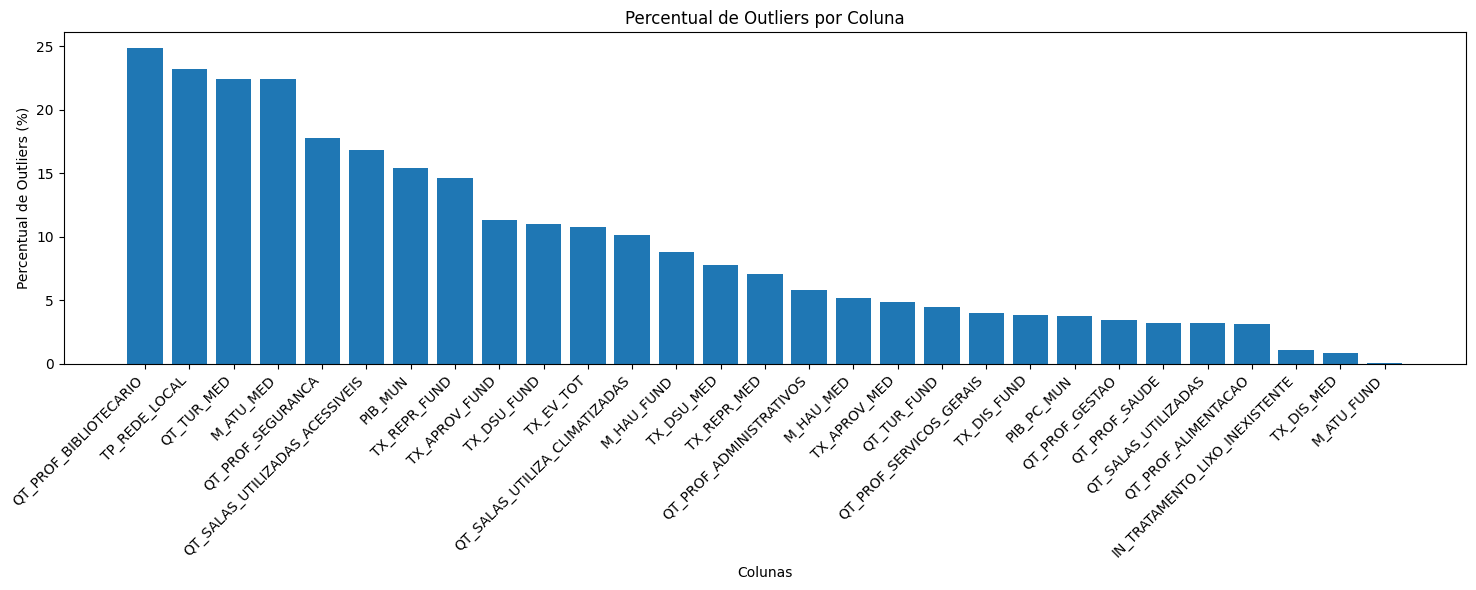

In [19]:
# Visualiza um panorama geral dos outliers de todas as colunas
def analise_outliers(df):
    # Selecionar apenas colunas numéricas
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    # Criar um dataframe para armazenar os resultados
    outliers_summary = pd.DataFrame(columns=['Coluna', 'Total_Outliers', 'Percentual_Outliers', 'Limite_Inferior', 'Limite_Superior'])
    
    for col in numeric_cols:
        # Calcular Q1, Q3 e IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Calcular limites para outliers
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        
        # Identificar outliers
        outliers = df[(df[col] < limite_inferior) | (df[col] > limite_superior)][col]
        total_outliers = len(outliers)
        percentual_outliers = (total_outliers / len(df)) * 100
        
        # Adicionar resultados ao dataframe
        outliers_summary.loc[len(outliers_summary)] = [
            col,
            total_outliers,
            round(percentual_outliers, 2),
            round(limite_inferior, 2),
            round(limite_superior, 2)
        ]
    
    # Ordenar por percentual de outliers
    outliers_summary = outliers_summary.sort_values('Percentual_Outliers', ascending=False)
    
    return outliers_summary

# Executar a análise
resultado_outliers = analise_outliers(df_censo_eda)

# Exibir o resultado
print("\nResumo dos Outliers por Coluna:")
print("--------------------------------")
print(resultado_outliers)

# Criar um gráfico de barras para visualizar o percentual de outliers
plt.figure(figsize=(15, 6))
plt.bar(resultado_outliers['Coluna'], resultado_outliers['Percentual_Outliers'])
plt.xticks(rotation=45, ha='right')
plt.title('Percentual de Outliers por Coluna')
plt.xlabel('Colunas')
plt.ylabel('Percentual de Outliers (%)')
plt.tight_layout()
plt.show()

## Tratamento de outliers

### TP_REDE_LOCAL

possui 23% de outliers, valor 9 - Não informado
Então será cruzado com a coluna de IN_INTERNET para substituir por 0 e se sobrar alguém iremos remover

Quantidade inicial de registros com valor 9 em TP_REDE_LOCAL: 30176

Quantidade restante de registros com valor 9 em TP_REDE_LOCAL: 21904

Distribuição atual dos valores em TP_REDE_LOCAL:
TP_REDE_LOCAL
3    30.77
1    25.52
9    16.83
2    15.82
0    11.06
Name: proportion, dtype: float64

Cruzamento entre TP_REDE_LOCAL e IN_INTERNET:
IN_INTERNET    False  True 
TP_REDE_LOCAL              
0               3643  10750
1                216  32993
2                109  20479
3                 70  39965
9              21904      0


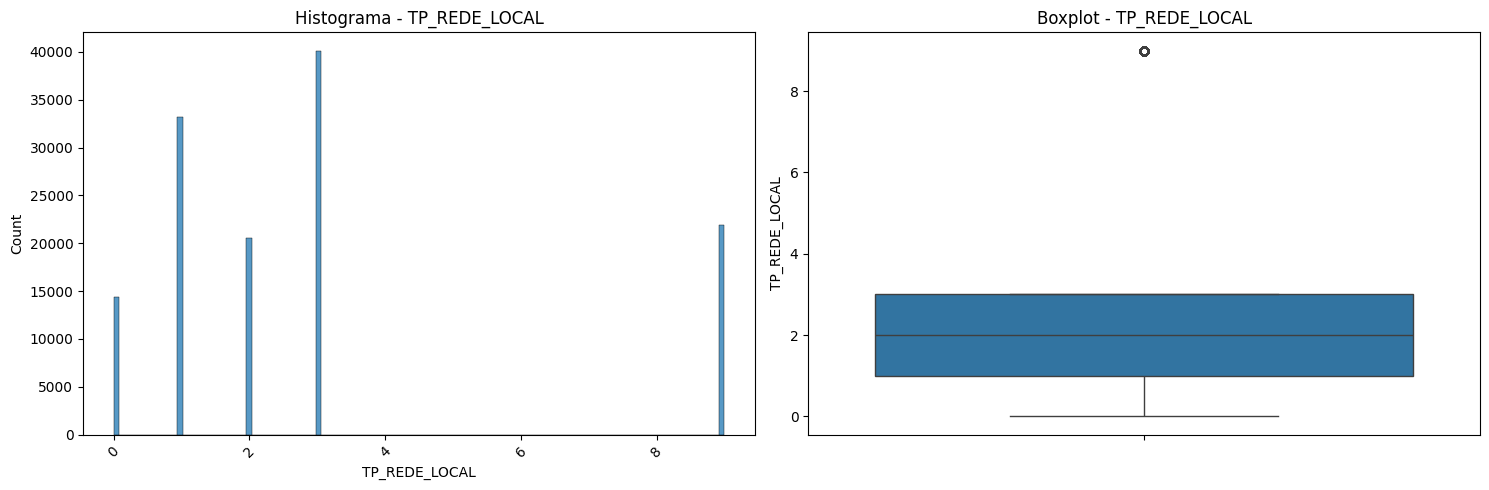

In [20]:
# Verificar a quantidade inicial de registros com valor 9
print("Quantidade inicial de registros com valor 9 em TP_REDE_LOCAL:", 
      len(df_censo_eda[df_censo_eda['TP_REDE_LOCAL'] == 9]))

# Substituir valor 9 por 0 quando IN_INTERNET for 1
df_censo_eda.loc[(df_censo_eda['TP_REDE_LOCAL'] == 9) & 
                 (df_censo_eda['IN_INTERNET'] == 1), 'TP_REDE_LOCAL'] = 1

# Verificar quantos registros ainda têm valor 9
print("\nQuantidade restante de registros com valor 9 em TP_REDE_LOCAL:", 
      len(df_censo_eda[df_censo_eda['TP_REDE_LOCAL'] == 9]))

# Verificar a distribuição atual dos valores em TP_REDE_LOCAL
print("\nDistribuição atual dos valores em TP_REDE_LOCAL:")
print(df_censo_eda['TP_REDE_LOCAL'].value_counts(normalize=True).multiply(100).round(2))

# Mostrar cruzamento entre TP_REDE_LOCAL e IN_INTERNET
print("\nCruzamento entre TP_REDE_LOCAL e IN_INTERNET:")
print(pd.crosstab(df_censo_eda['TP_REDE_LOCAL'], df_censo_eda['IN_INTERNET']))

exibe_graficos_coluna(df_censo_eda, 'TP_REDE_LOCAL')